<a href="https://colab.research.google.com/github/Niloofar-SecML/CNN/blob/main/MobileNet_Pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Define the path to the dataset in Google Drive
data_path = '/content/drive/MyDrive/flower_photos/'

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [16]:
# Load the dataset without applying transformations
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    image_size=(256, 256),
    batch_size=32,
    validation_split=0.2,
    subset="training",
    seed=123,
)

# Retrieve class names
class_names = train_dataset.class_names
print("Class names:", class_names)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Class names: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


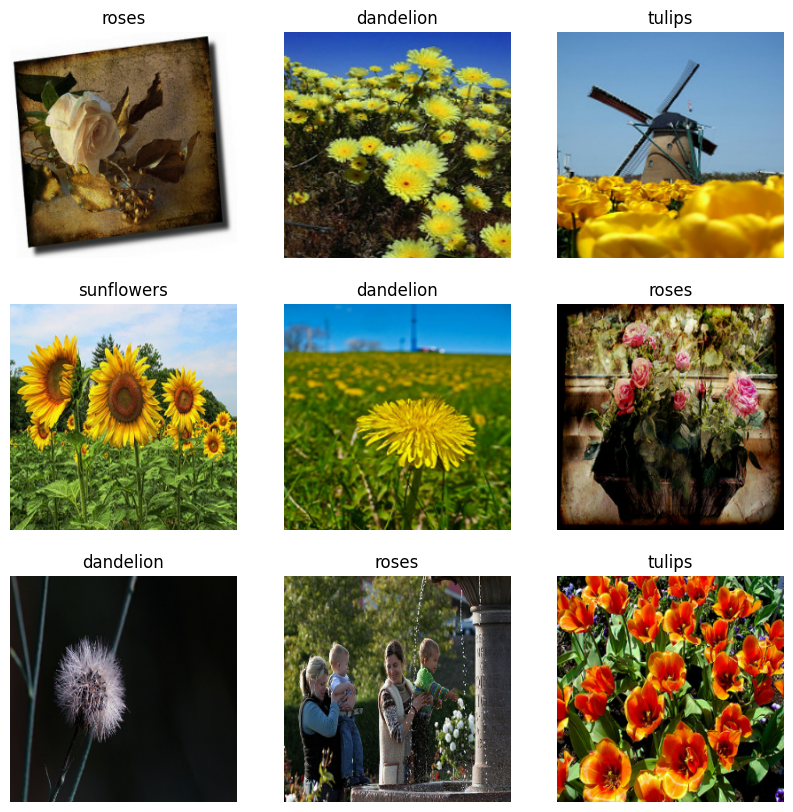

In [17]:
# Visualize a few images from the training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):  # Take one batch of images
    for i in range(9):  # Plot 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])  # Use class names to label images
        plt.axis("off")
plt.show()

In [20]:
# Define the data augmentation function
def data_augmenter():
    return tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
    ])

# Create the data augmentation layer
data_augmentation_layer = data_augmenter()

# Apply data augmentation to the training dataset
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation_layer(x), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

# Prefetch data for performance optimization
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

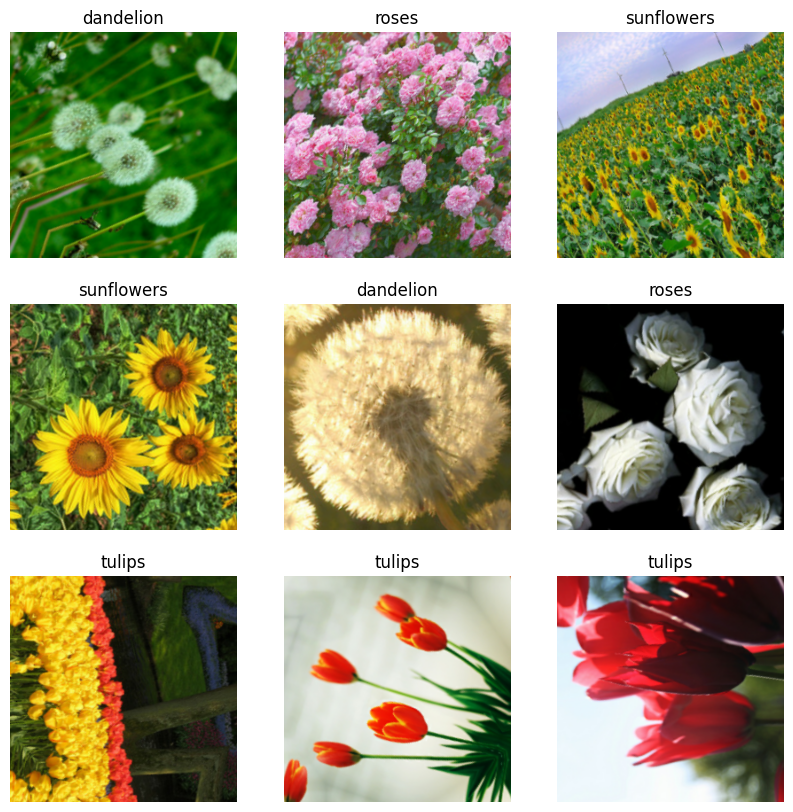

In [21]:
# Visualize a few augmented images from the training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):  # Take one batch of augmented images
    for i in range(9):  # Plot 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy()])  # Use numpy to access labels
        plt.axis("off")
plt.show()

In [22]:
# Load MobileNetV2 without the top layer
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
# Resize images to 224x224
image_size = (224, 224)

train_dataset = train_dataset.map(
    lambda x, y: (tf.image.resize(x, image_size), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

val_dataset = val_dataset.map(
    lambda x, y: (tf.image.resize(x, image_size), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)


In [25]:
#build thhe model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

In [26]:
#compile the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

In [27]:
#train model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 351s 4s/step - accuracy: 0.2274 - loss: 1.7900 - val_accuracy: 0.2500 - val_loss: 1.5786
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.4250 - loss: 1.4003 - val_accuracy: 0.2852 - val_loss: 1.5869
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.4912 - loss: 1.2773 - val_accuracy: 0.4375 - val_loss: 1.3130
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.5285 - loss: 1.2226 - val_accuracy: 0.4180 - val_loss: 1.3769
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 247s 2s/step - accuracy: 0.5628 - loss: 1.1392 - val_accuracy: 0.4570 - val_loss: 1.3221
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.5738 - loss: 1.1142 - val_accuracy: 0.4688 - val_loss: 1.2712
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.5922 - loss: 1.0848 - val_accuracy: 0.4727 - val_loss: 1.2594
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.5969 - loss: 1.0663 - val_accuracy: 0.4805 - v

In [28]:
# Unfreeze the last 30 layers of the base model
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompile the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    metrics=['accuracy']
)

# Continue training
history_finetune = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5
)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step - accuracy: 0.3959 - loss: 1.5506 - val_accuracy: 0.4453 - val_loss: 1.3217
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - accuracy: 0.5403 - loss: 1.1845 - val_accuracy: 0.4727 - val_loss: 1.2958
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.5779 - loss: 1.1029 - val_accuracy: 0.4883 - val_loss: 1.2489
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 252s 3s/step - accuracy: 0.5862 - loss: 1.0555 - val_accuracy: 0.4883 - val_loss: 1.2463
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 251s 3s/step - accuracy: 0.6129 - loss: 1.0200 - val_accuracy: 0.4922 - val_loss: 1.2384


In [29]:
# Load MobileNetV2 without the top layer
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model
base_model.trainable = False

In [31]:
#pretraind model
import tensorflow as tf

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False


In [32]:
#add custome layer
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [34]:
#compile model
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

In [36]:
#train model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.2080 - loss: 1.0444 - val_accuracy: 0.4648 - val_loss: 1.4479
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.2557 - loss: -3.3581 - val_accuracy: 0.4648 - val_loss: 3.1311
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.2618 - loss: -6.7925 - val_accuracy: 0.4648 - val_loss: 4.9936
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.2520 - loss: -10.3058 - val_accuracy: 0.4648 - val_loss: 6.9176
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.2583 - loss: -14.1040 - val_accuracy: 0.4648 - val_loss: 8.8860
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.2568 - loss: -17.7325 - val_accuracy: 0.4648 - val_loss: 10.8905
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.2520 - loss: -21.7999 - val_accuracy: 0.4648 - val_loss: 12.9320
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.2515 - loss: -25.3237 - val_accura

In [37]:
#fine tune model
base_model.trainable = True
fine_tune_at = 100  # Unfreeze from the 100th layer onwards

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    metrics=['accuracy']
)

history_finetune = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5
)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 303s 3s/step - accuracy: 0.2562 - loss: -35.5832 - val_accuracy: 0.4648 - val_loss: 16.0737
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 330s 3s/step - accuracy: 0.2593 - loss: -41.1439 - val_accuracy: 0.4648 - val_loss: 13.1130
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 287s 3s/step - accuracy: 0.2531 - loss: -49.3687 - val_accuracy: 0.4648 - val_loss: 10.1794
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 290s 3s/step - accuracy: 0.2566 - loss: -59.5439 - val_accuracy: 0.4648 - val_loss: 7.6285
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 318s 3s/step - accuracy: 0.2586 - loss: -72.4643 - val_accuracy: 0.4727 - val_loss: 5.4908


In [38]:
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4616 - loss: 5.6712
Validation Accuracy: 47.27%
